In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from earlystop import EarlyStopper
from lstm_models import AirModel, StackLSTM


#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file7_080124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.134180,0.023473,0.002203,0.002203-0.001490j,0.002659,-0.594742,-0.051439
1,0.135824,0.025117,0.002051,0.002051+0.000170j,0.002058,0.082612,-0.020024
2,0.136482,0.025775,0.001900,0.001900+0.000303j,0.001924,0.158163,0.009547
3,0.137797,0.027090,0.001749,0.001749+0.000903j,0.001969,0.476669,0.035605
4,0.137797,0.027090,0.001599,0.001599+0.000993j,0.001882,0.555726,0.056848


## **dataset**

In [3]:
amplitudes = df['Amplitude'][300:90300].values
train, val = utils.split_data(amplitudes)
x_train, y_train = utils.create_dataset(train, 100)
x_val, y_val = utils.create_dataset(val, 100)
train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)

print(x_train.shape, y_train.shape ,x_val.shape, y_val.shape)

torch.Size([7900, 100, 1]) torch.Size([7900, 100, 1]) torch.Size([1900, 100, 1]) torch.Size([1900, 100, 1])


## **model**

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0001533996048002237, Test Loss: 1.688852738273757e-05
Epoch: 0, Loss: 1.7330252376268618e-05


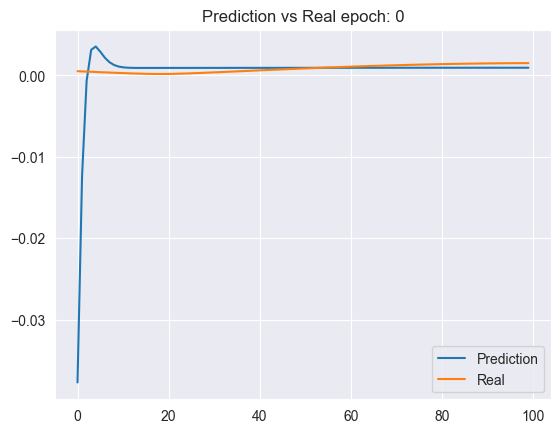

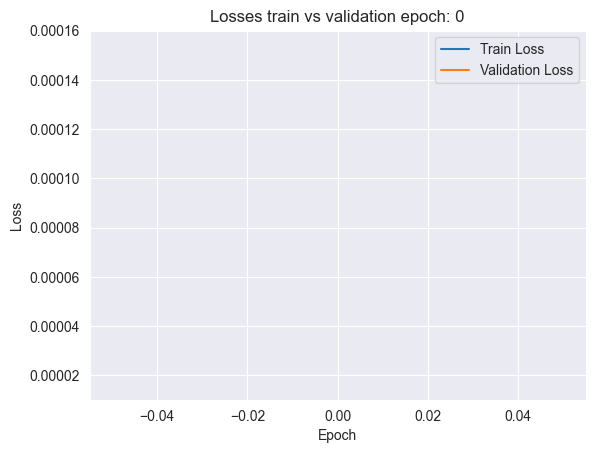

 20%|██        | 2/10 [00:13<00:53,  6.69s/it]

Epoch: 2, Train Loss: 3.4588366261858262e-06, Test Loss: 1.7627336376335735e-06
Epoch: 2, Loss: 1.853717094491003e-06


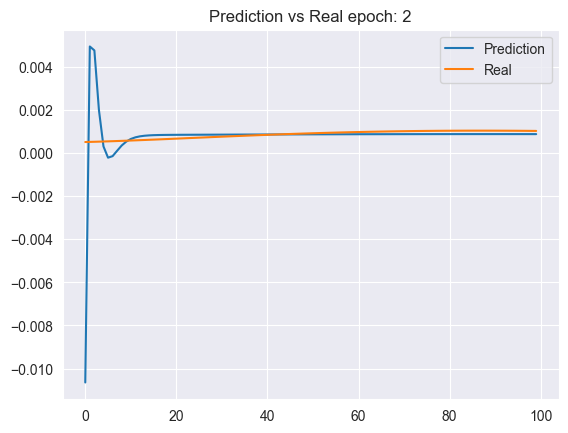

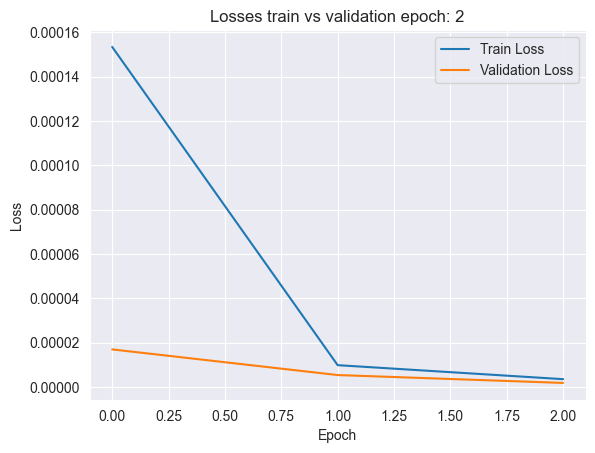

 40%|████      | 4/10 [00:26<00:39,  6.61s/it]

Epoch: 4, Train Loss: 5.255114200531629e-07, Test Loss: 1.7577380238738744e-07
Epoch: 4, Loss: 4.029819535844581e-07


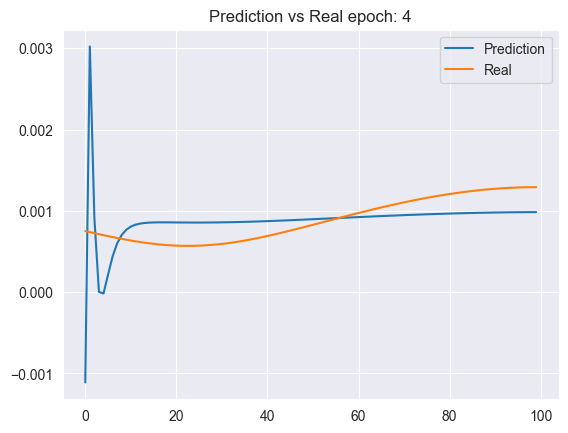

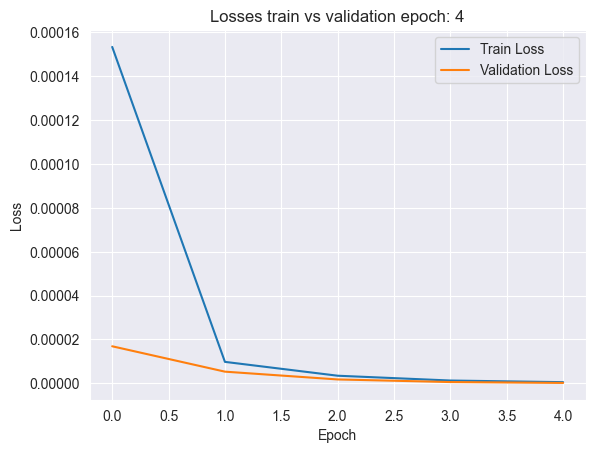

 60%|██████    | 6/10 [00:40<00:26,  6.62s/it]

Epoch: 6, Train Loss: 2.0993664212710887e-07, Test Loss: 5.3521766278189865e-08
Epoch: 6, Loss: 1.763976769098008e-07


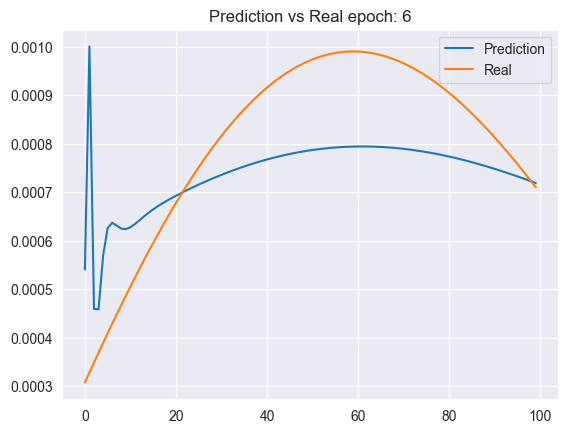

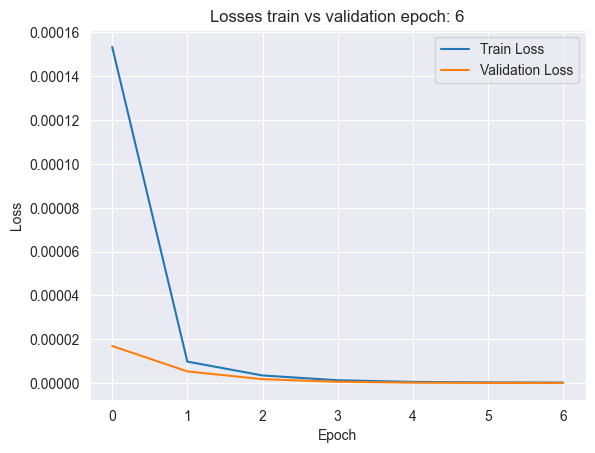

 80%|████████  | 8/10 [00:53<00:13,  6.66s/it]

Epoch: 8, Train Loss: 1.38652592255942e-07, Test Loss: 3.758820999640496e-08
Epoch: 8, Loss: 1.2152948158927757e-07


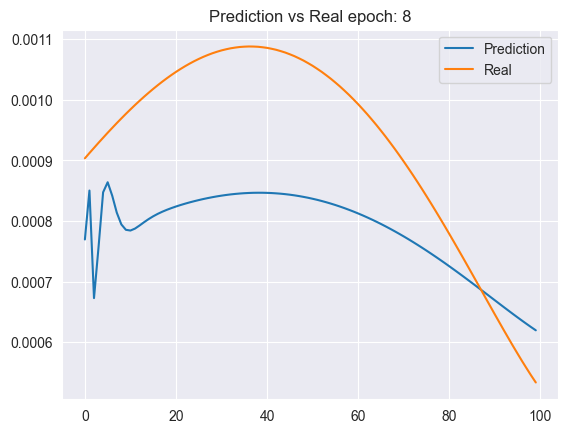

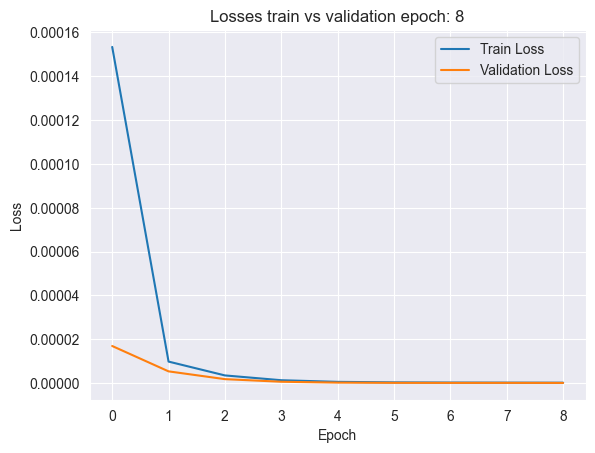

100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


In [4]:
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
n_epochs = 10
ncheckpoint = 2

m, av_train, av_val = utils.train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs, ncheckpoint)



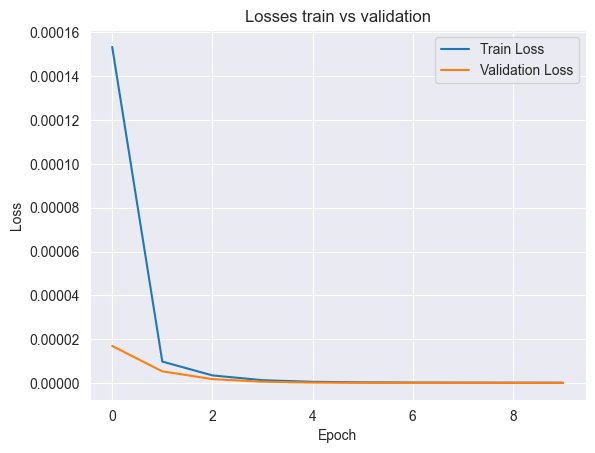

In [7]:
plt.plot(av_train, label='Train Loss')
plt.plot(av_val, label='Validation Loss')
plt.title('Losses train vs validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

## **load model and test**

In [33]:
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
n_epochs = 10
ncheckpoint = 2
filename = 'model_epoch490.pth'

utils.resume(model, optimizer, filename)


In [11]:
amp = df['Amplitude'][30000:40000].values

x_test, y_test = utils.create_dataset(amp, 100)
test_loader = utils.create_loader(x_test, y_test, 32)


In [21]:
y_test.shape

torch.Size([9900, 100, 1])

In [34]:
x = utils.predictions(model, test_loader)


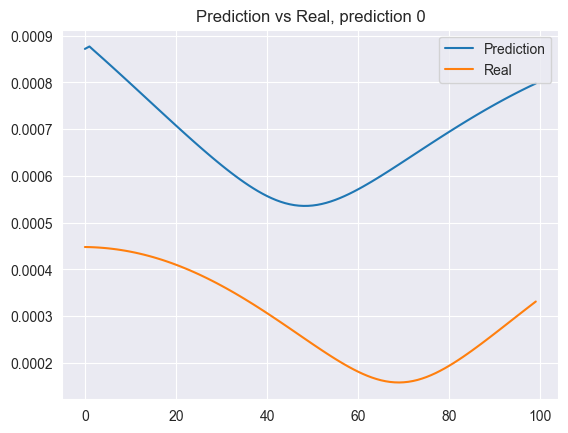

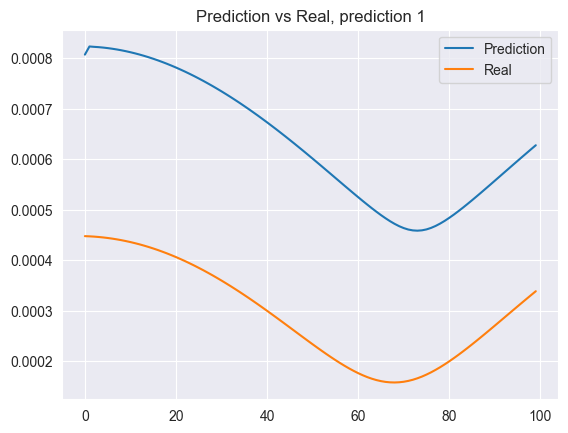

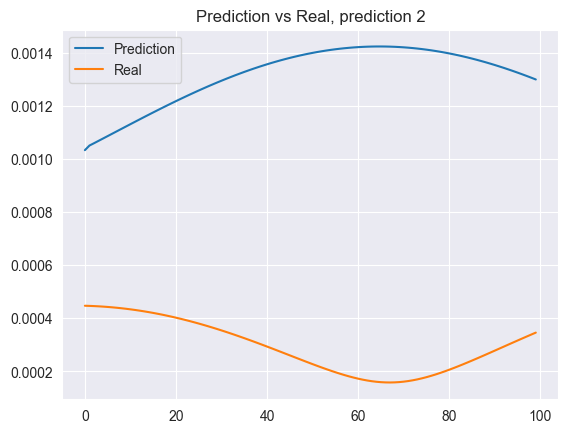

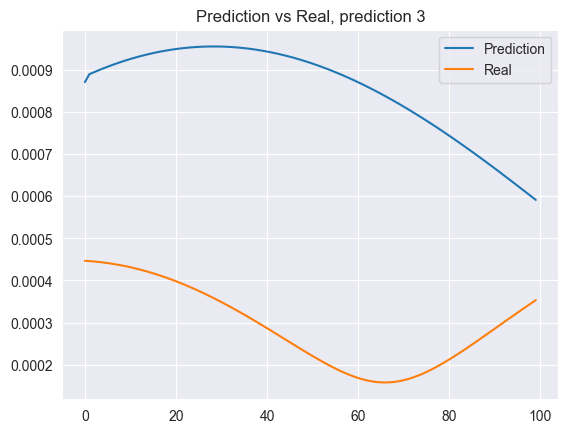

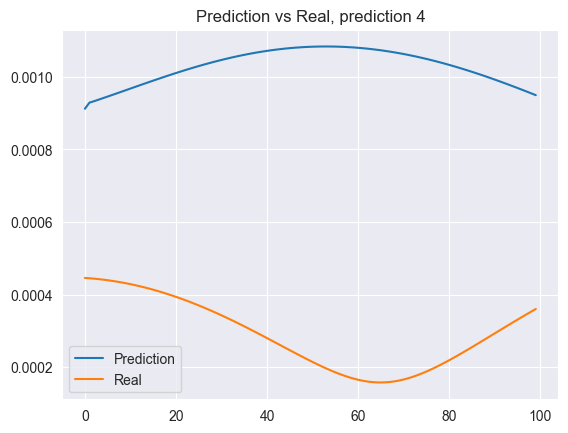

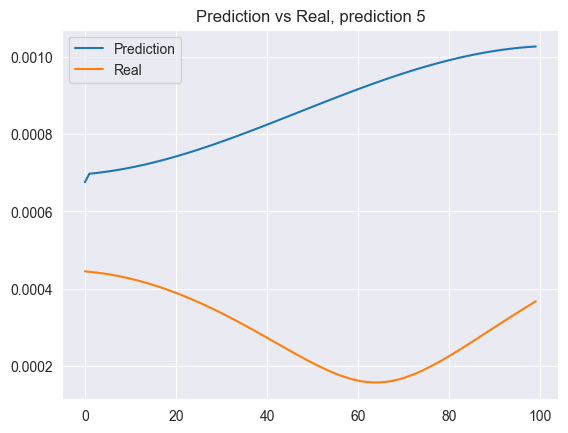

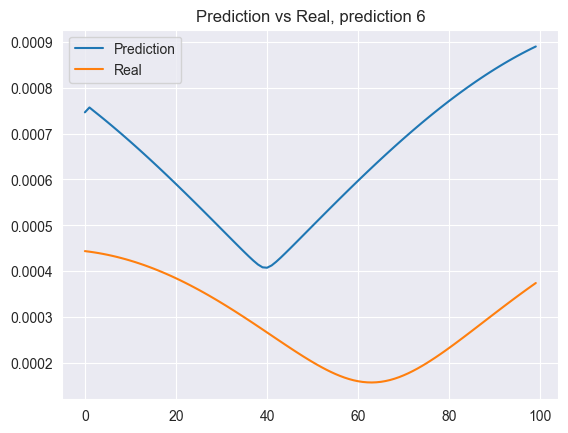

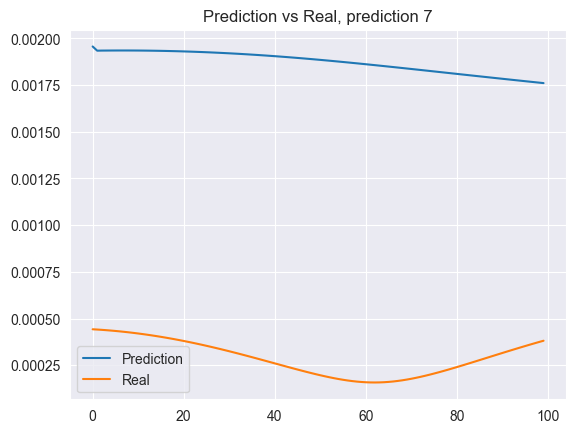

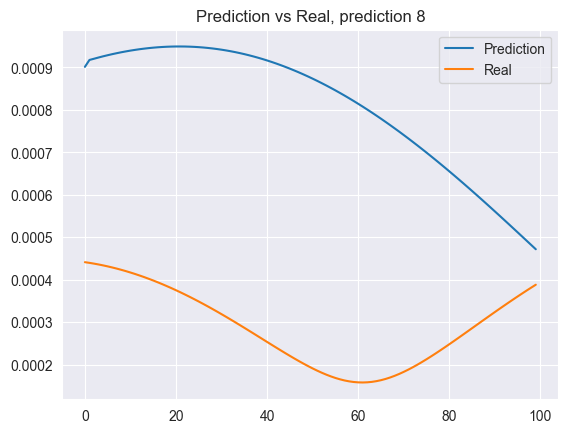

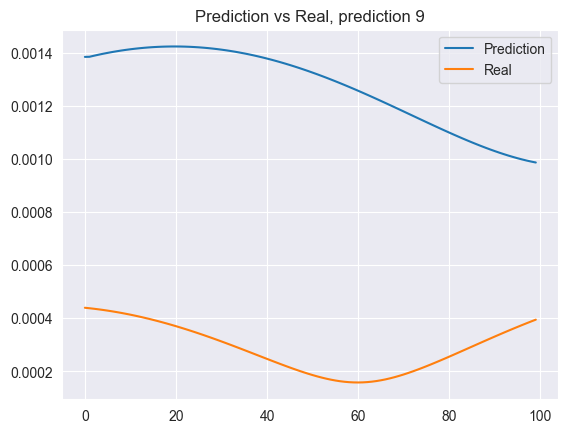

In [35]:
for i in range(10):
    plt.plot(x[i].numpy(), label = 'Prediction')
    plt.plot(y_test[i].numpy(), label = 'Real')
    plt.title('Prediction vs Real, prediction {}'.format(i))
    plt.legend()
    plt.show()
    plt.close()